## "Detection of Anomalies in Financial Transactions using Deep Autoencoder Networks"

This GPU Technology Conference (GTC) 2018 lab was developed by Mr. X, and Mr. Y

## 01. Environment Verification

#### 01.1 Python Verification

Before we begin, let's verify that Python is working on your system. To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Shift-Enter, or pressing the play button in the toolbar above. If all goes well, you should see some output returned below the grey cell.

In [ ]:
print('The answer should be forty-two: {}'.format(str(40+2)))

#### 01.2 Import Python Libraries

In [4]:
# importing utilities
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, display

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

In [13]:
USE_CUDA = True

#### 01.3 CUDNN / GPU Verficiation

In [2]:
# print CUDNN backend version
print('The CUDNN backend version: {}'.format(torch.backends.cudnn.version()))

The CUDNN backend version: None


Let's execute the cell below to display information about the GPUs running on the server.

In [3]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


Let's execute the cell below to display information about the PyTorch version running on the server.

In [4]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] PyTorch version: {}'.format(now, torch.__version__))

[LOG 20180213-13:53:00] PyTorch version: 0.3.0.post4


## 02. Motivation and Lab Objective

This lab focuses on the detection of anomalous records in financial data using a special type of deep neural networks, usually referred to as autoencoder neural networks (AENN), to uncover potential traced of financial fraud and abuse. 

The goal of this lab is to give you a deep learning (DL) approach that can be potentially beneficial to the complex detection of fraudulent activities in financial datasets. Please note, that this lab is not a complete nor comprehensive forensic data analysis approach or fraud examination strategy. Rather, it shows how AENN based deep neural networks can be applied to detect anomalous records. The code provided in this lab can be repurposed or adopted to detect anomalous records in a variety of financial datasets. The detected records might serve as a starting point for a more detailed and substantive examination by auditors or compliance personel. 

In this lab, it is assumed that you are familiar with the general concepts of deep neural networks (DNN), GPUs,  PyTorch, and Python. For more information on DNN, GPUs, and PyTorch, please check the relevant labs in DLI. 

<img align="middle" style="max-width: 550px; height: auto" src="images/accounting.png">

<img align="middle" style="max-width: 550px; height: auto" src="images/anomalies.png">

<img align="middle" style="max-width: 400px; height: auto" src="images/cube.gif">

## 3. Autoencoder Neural Networks

In this section, we will cover the major building blocks and the specifc network structure of deep AENNs as well as an exemplary implementation using the open source machine learning libary PyTorch. The objective of this section is to familiarize with the underlying idea and concepts of building a deep AENN.

### 3.1 Autoencoder Neural Network Architecture

AENNs or replicator neural network are a variant of general feed-forward neural networks that have been initally introduced by xxx. AENNs comprise a specially designed network architecture that can be trained in a "self-supervised" manner to reconstruct its input. Figure XX illustrates a schematic view of an AENN.

<img align="middle" style="max-width: 600px; height: auto" src="images/autoencoder.png">

**Figure XX:** Schematic view of an autoencoder network comprised of two non-linear mappings (fully connected feed forward neural networks) referred to as encoder $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ and decoder $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dy}$.

AAEN can be interepreted as "lossy" data compression algorithms. They are "lossy" in a sense that the reconstructed outputs will be degraded compared to the original inputs. The difference between the original input and its reconstruction is referred to as reconstruction error. In general AENN encompass three major building blocks:


   1. an encoding mapping function $f_\theta$, 
   2. a decoding mapping function $g_\theta$, 
   3. and a loss function $\mathcal{L_{\theta}}$.

Most commonly the encoder and the decoder mapping functions are of symmetrical architecture consisting of several layers of neurons followed by a nonlinear function and shared parameters θ. The encoder mapping $f_\theta(\cdot)$ maps an input vector $x^i$ to compressed representation $z^i$ referred to as latent space $Z$. This hidden representation $z^i$ is then mapped back by the decoder $g_\theta(\cdot)$ to a re-constructed vector $x^i$ of the original input space. Formally, the nonlinear mappings of the encoder and the decoder can be defined by:

<center>$f_\theta(x^i) = s(Wx^i + b)$, and $g_\theta(z^i) = s′(W′z^i + d)$,</center>

where $s$ and $s′$ denote a non-linear activations with model parameters $\theta = \{W, b, W', d\}$, $W \in \mathbb{R}^{d_x \times d_z}, W' \in \mathbb{R}^{d_z \times d_y}$ are weight matrices and $b \in \mathbb{R}^{dx}$, $d \in \mathbb{R}^{dz}$ are the offset bias vectors.

### 3.2 Autoencoder Neural Network Training

In an attempt to achieve $x^{i} \approx \hat{x}^{i}$ the autoencoder neural network can be trained to learn a set of encoder-decoder model parameters $\theta$ that minimize the dissimilarity of a given journal entry $x^{i}$ and its reconstruction $\hat{x}^{i} = g_\theta(f_\theta(x^{i}))$ as faithfully as possible. Thereby, the training objective is to learn a set of optimal shared encoder-decoder model parameters $\theta^*$ that optimizes $\arg\min_{\theta} \|X - g_\theta(f_\theta(X))\|$ over all journal entries $X$.

To achieve this optimization objective one typically minimizes a loss function $\mathcal{L_{\theta}}$ as part of the network training. In this lab we use the mean squared error (MSE) reconstruction loss, defined by:

<center>$\mathcal{L^{MSE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{k} \sum_{j=1}^{k}{(x^{i}_{j} - \hat{x}^{i}_{j})}^2$,</center>

for a set of $n$-journal entries $x^{i}$, $i=1,...,n$ and their respective reconstructions $\hat{x}^{i}$ over all journal entry attributes $j=1,...,k$.

### 3.3 Autoencoder Neural Network Implementation

Now, let's start the AENN implementation by first implementing the encoder network using PyTorch. For the encoder network model we aim to implement an architecture consisting of six fully-connected layers (FCL) specified by "128-64-32-16-8-3", meaning the first layer consists of 128 neurons, the second layer of 64 neurons and the subsequent layers of 32, 16, 8 and 3 neurons.

In order to speed up training convergence and to avoid "dying ReLUs" we use Leaky ReLUs as non-linear activation functions. Finally, we also apply droupout with a probability of 20% for each neuron to be set to zero at a forward pass to prevent the network from overfitting.

In [7]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        self.dropout = nn.Dropout(p=0.0, inplace=True)

        # specify layer 1 - in 186, out 128
        self.encoder_L1 = nn.Linear(186, 128, bias=True) # add linearity 
        nn.init.xavier_uniform(self.encoder_L1.weight) # init weights according to [todo]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [todo]

        # specify layer 2 - in 128, out 64
        self.encoder_L2 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 64, out 32
        self.encoder_L3 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 32, out 16
        self.encoder_L4 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 16, out 8
        self.encoder_L5 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 3
        self.encoder_L6 = nn.Linear(8, 3, bias=True)
        nn.init.xavier_uniform(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.encoder_L6(x)) # don't apply dropout to the AE bottleneck

        return x

Now, we are now ready to initialize the network locally or using CUDNN (to utilize potential available GPUs for computation). Once initialized let's print and review the implemented network architecture.

In [15]:
# init training network classes / architectures
encoder_train = encoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder().cuda()

# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20180215-12:19:16] encoder architecture:

encoder(
  (dropout): Dropout(p=0.0, inplace)
  (encoder_L1): Linear(in_features=186, out_features=128)
  (encoder_R1): LeakyReLU(0.4, inplace)
  (encoder_L2): Linear(in_features=128, out_features=64)
  (encoder_R2): LeakyReLU(0.4, inplace)
  (encoder_L3): Linear(in_features=64, out_features=32)
  (encoder_R3): LeakyReLU(0.4, inplace)
  (encoder_L4): Linear(in_features=32, out_features=16)
  (encoder_R4): LeakyReLU(0.4, inplace)
  (encoder_L5): Linear(in_features=16, out_features=8)
  (encoder_R5): LeakyReLU(0.4, inplace)
  (encoder_L6): Linear(in_features=8, out_features=3)
  (encoder_R6): LeakyReLU(0.4, inplace)
)



Let's complete the AENN implementation by implementing the decoder network. The design of the decoder network architecture also consists of six fully-connected layers (FCL) and is intended to mirror the encoder network architecture by a layerwise inversion "8-16-32-64-128-186" of the encoder layers.

In [34]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        self.dropout = nn.Dropout(p=0.0, inplace=True)

        # specify layer 1 - in 3, out 8
        self.decoder_L1 = nn.Linear(3, 8, bias=True) # add linearity 
        nn.init.xavier_uniform(self.decoder_L1.weight)  # init weights according to [todo]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [todo]

        # specify layer 1 - in 8, out 16
        self.decoder_L2 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 16, out 32
        self.decoder_L3 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 32, out 64
        self.decoder_L4 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 64, out 128
        self.decoder_L5 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 1 - in 128, out 186
        self.decoder_L6 = nn.Linear(128, 186, bias=True)
        nn.init.xavier_uniform(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.decoder_L6(x)) # don't apply dropout to the AE output
        
        return x

Let's again initialize the implemented network and correspondingly convince ourselves that it was successfully initialized by printing and reviewing the initialized architecture.

In [35]:
# init training network classes / architectures
decoder_train = decoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None):
    decoder_train = decoder().cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20180215-14:04:18] decoder architecture:

decoder(
  (dropout): Dropout(p=0.0, inplace)
  (decoder_L1): Linear(in_features=3, out_features=8)
  (decoder_R1): LeakyReLU(0.4, inplace)
  (decoder_L2): Linear(in_features=8, out_features=16)
  (decoder_R2): LeakyReLU(0.4, inplace)
  (decoder_L3): Linear(in_features=16, out_features=32)
  (decoder_R3): LeakyReLU(0.4, inplace)
  (decoder_L4): Linear(in_features=32, out_features=64)
  (decoder_R4): LeakyReLU(0.4, inplace)
  (decoder_L5): Linear(in_features=64, out_features=128)
  (decoder_R5): LeakyReLU(0.4, inplace)
  (decoder_L6): Linear(in_features=128, out_features=186)
  (decoder_R6): LeakyReLU(0.4, inplace)
)



## 04. Financial Fraud Detection Dataset

The dataset is extracted from Kaggle datasets repository at the following link: 
https://www.kaggle.com/ntnu-testimon/paysim1

In [16]:
# load the dataset
ori_dataset = pd.read_csv("./data/PS_20174392719_1491204439457_log.csv", sep=",", header=0, encoding="utf-8")

In [17]:
ori_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [18]:
# dimension of data
ori_dataset.shape 

(6362620, 11)

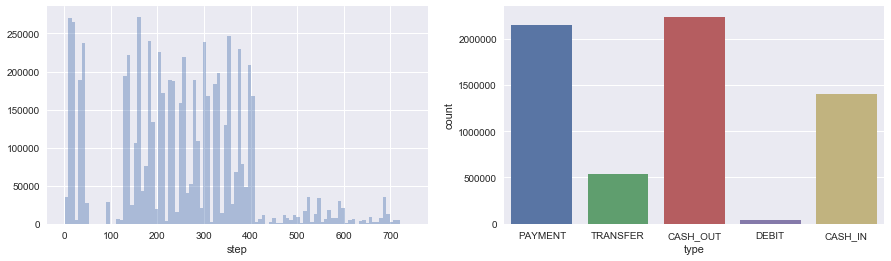

In [19]:
# plot "step" and "type" attributes
sns.set()
fig, ax =plt.subplots(1,2)
fig.set_figwidth(15)
sns.distplot(ori_dataset['step'], kde=False, bins=100, ax=ax[0])
sns.countplot(x=ori_dataset['type'], ax=ax[1])

In [20]:
# let's have a look what "type" do fraudulent transactions possess
ori_dataset[ori_dataset['isFraud'] == 1]['type'].unique()

array([u'TRANSFER', u'CASH_OUT'], dtype=object)

In [21]:
# we select a subset of "type": "transfer" ("cash-out" may be selected for optional excercise)
ori_subset = ori_dataset[ori_dataset['type'] == 'TRANSFER']

In [22]:
# dimension of data
ori_subset.shape

(532909, 11)

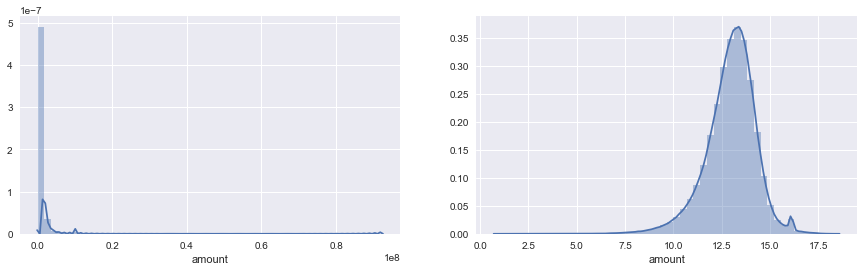

In [23]:
# plot "amount" attribute and its log scale
fig, ax =plt.subplots(1,2)
fig.set_figwidth(15)
sns.distplot(ori_subset['amount'], ax=ax[0])
sns.distplot(ori_subset['amount'].apply(np.log), ax=ax[1])

Preprocess numeric attributes

In [24]:
# select numeric attributes
numeric_attr_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
epsilon = 1e-7

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_subset[numeric_attr_names] + epsilon
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attribute to the range [0,1]
numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

# append 'isFraud' attribute
numeric_attr['isFraud'] = ori_subset['isFraud']

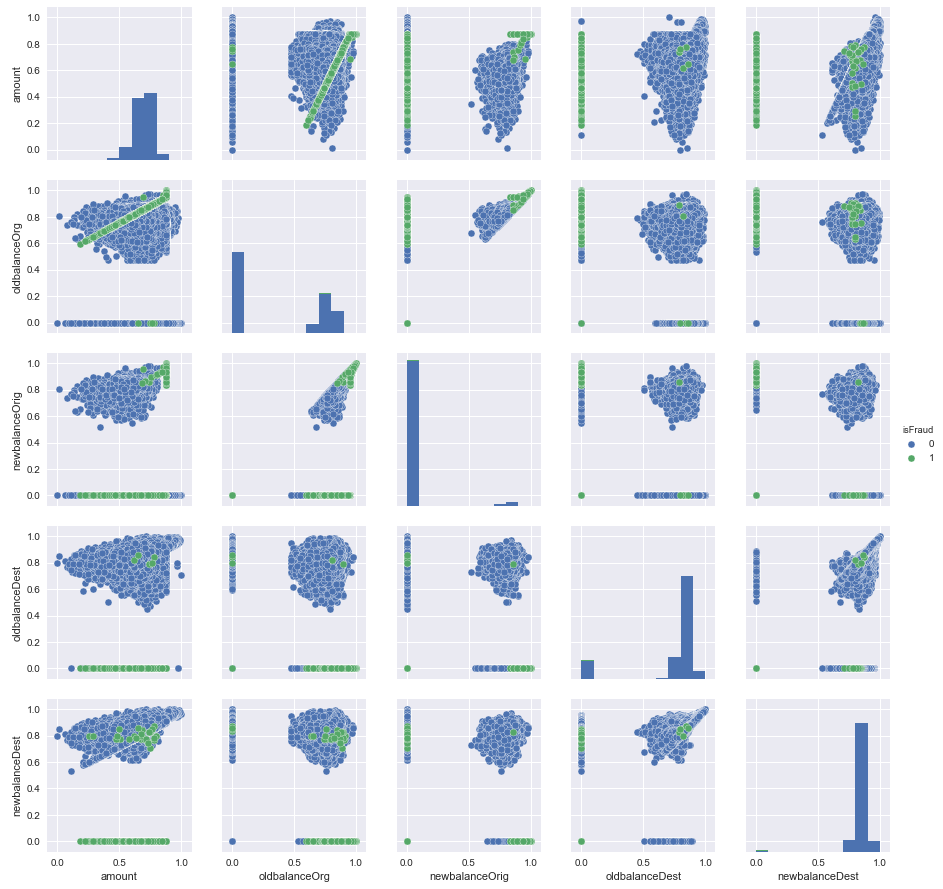

In [25]:
# plot numeric attributes scaled under natural log
if os.path.exists('./images/numeric_attr_pair_plot.png'):
    display(Image('./images/numeric_attr_pair_plot.png'))
else:
    sns.pairplot(data=numeric_attr, vars=numeric_attr_names, hue='isFraud')

In [26]:
# number of distinct values possessed by 'nameOrig'
ori_subset['nameOrig'].nunique()

532839

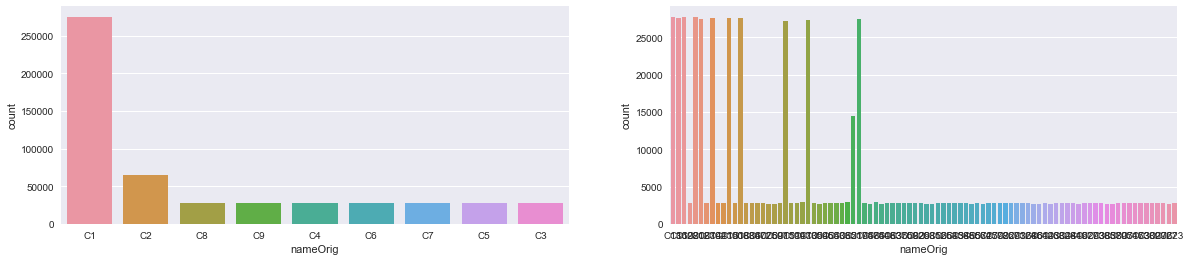

In [27]:
# if we select first 2 or 3 characters
nameOrig_slice_2 = ori_subset['nameOrig'].str.slice(0, 2)
nameOrig_slice_3 = ori_subset['nameOrig'].str.slice(0, 3)

nameDest_slice_2 = ori_subset['nameDest'].str.slice(0, 2)
nameDest_slice_3 = ori_subset['nameDest'].str.slice(0, 3)

fig, ax =plt.subplots(1,2)
fig.set_figwidth(20)
sns.countplot(x=nameOrig_slice_2, ax=ax[0])
sns.countplot(x=nameOrig_slice_3, ax=ax[1])
# g.set_xticklabels(rotation=90)

In [28]:
# select categorical attributes
ori_subset_categ = pd.concat([ori_subset['type'], nameOrig_slice_3, nameDest_slice_3], 
                             axis = 1,
                             names = ['type', 'nameOrig', 'nameDest'])
# select numeric attributes
ori_subset_numeric = numeric_attr.drop('isFraud', axis=1)

In [29]:
# transform categorcal attributes into a sparse representation uning one-hot transformation
ori_subset_categ_transformed = pd.get_dummies(ori_subset_categ)

In [30]:
# join categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_subset_categ_transformed, ori_subset_numeric],
                                   axis = 1)
ori_subset_transformed.shape

(532909, 186)

In [32]:
# prepate the dataset for pytorch loader
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

## 05. Network Training

ToDo - Timur and Marco

In [36]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
# torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

# init training parameters
num_epochs = 50
mini_batch_size = 128
learning_rate = 1e-3

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# set num_workers to zero to retreive deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None):

    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

# define optimization criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

# train autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    # determine if CUDA is available at compute node
    if (torch.backends.cudnn.version() != None) and (use_cuda == True):

        # set all networks / models in CPU mode
        encoder_train.cuda()
        decoder_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()

    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== forward pass =====================

        # run forward pass
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data

        # determine reconstruction loss
        reconstruction_loss = criterion(mini_batch_reconstruction, mini_batch_torch)

        # =================== backward pass ====================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== log ==============================

        if mini_batch_count % 100 == 0:

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {:.10f}'.format(now, (epoch+1), num_epochs, mini_batch_count, reconstruction_loss.data[0]))

    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))

[LOG 20180215-14_04_38] training status, epoch: [0001/0050], batch: 0100, loss: 0.0664954111
[LOG 20180215-14_04_39] training status, epoch: [0001/0050], batch: 0200, loss: 0.0659072474
[LOG 20180215-14_04_40] training status, epoch: [0001/0050], batch: 0300, loss: 0.0642899871
[LOG 20180215-14_04_41] training status, epoch: [0001/0050], batch: 0400, loss: 0.0645916015
[LOG 20180215-14_04_41] training status, epoch: [0001/0050], batch: 0500, loss: 0.0672187880
[LOG 20180215-14_04_42] training status, epoch: [0001/0050], batch: 0600, loss: 0.0664948300
[LOG 20180215-14_04_43] training status, epoch: [0001/0050], batch: 0700, loss: 0.0643545985
[LOG 20180215-14_04_43] training status, epoch: [0001/0050], batch: 0800, loss: 0.0657724813
[LOG 20180215-14_04_44] training status, epoch: [0001/0050], batch: 0900, loss: 0.0663702786
[LOG 20180215-14_04_44] training status, epoch: [0001/0050], batch: 1000, loss: 0.0643662512
[LOG 20180215-14_04_45] training status, epoch: [0001/0050], batch: 11

KeyboardInterrupt: 

## 06. Result Evaluation

In [37]:
# specify trained models to be loaded
encoder_model_name = "20180215-14_09_36_ep_10_encoder_model.pth"
decoder_model_name = "20180215-14_09_36_ep_10_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

In [38]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in training mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

In [39]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = criterion(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.data[0]))

[LOG 20180215-14:10:28] collected reconstruction loss of: 532909/532909 transactions
[LOG 20180215-14:10:28] reconstruction loss: 0.0166391656


In [40]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = criterion(reconstruction[i], data[i]).data[0]

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individial reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 20180215-14:10:28] collected individial reconstruction loss of: 000000/532909 transactions
[LOG 20180215-14:10:38] collected individial reconstruction loss of: 100000/532909 transactions
[LOG 20180215-14:10:50] collected individial reconstruction loss of: 200000/532909 transactions
[LOG 20180215-14:11:01] collected individial reconstruction loss of: 300000/532909 transactions
[LOG 20180215-14:11:11] collected individial reconstruction loss of: 400000/532909 transactions
[LOG 20180215-14:11:21] collected individial reconstruction loss of: 500000/532909 transactions


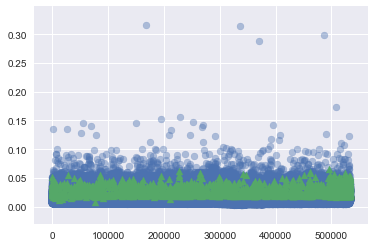

In [41]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), 
                             reconstruction_loss_transaction))

regular_data = plot_data[ori_subset.isFraud == 0]
fraud_data = plot_data[ori_subset.isFraud == 1]

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o") # plot regular transactions
ax.scatter(fraud_data[:, 0], fraud_data[:, 1], c='C1', marker="^") # plot fraudulent transactions


## 07. Optional Excercises

ToDo - Timur and Marco

## 08. Lab Summary

ToDo - Timur and Marco

## 09. Next Steps

ToDo - Timur and Marco

## XX. References